In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import shap
from evaluation import evaluate_global_shap_scores
import numpy as np

import warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to WARNING or ERROR
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

from shapflow import flow
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from shapflow.flow import Node, Graph, GraphExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from on_manifold import OnManifoldExplainer, IndExplainer


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']


rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42
    )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

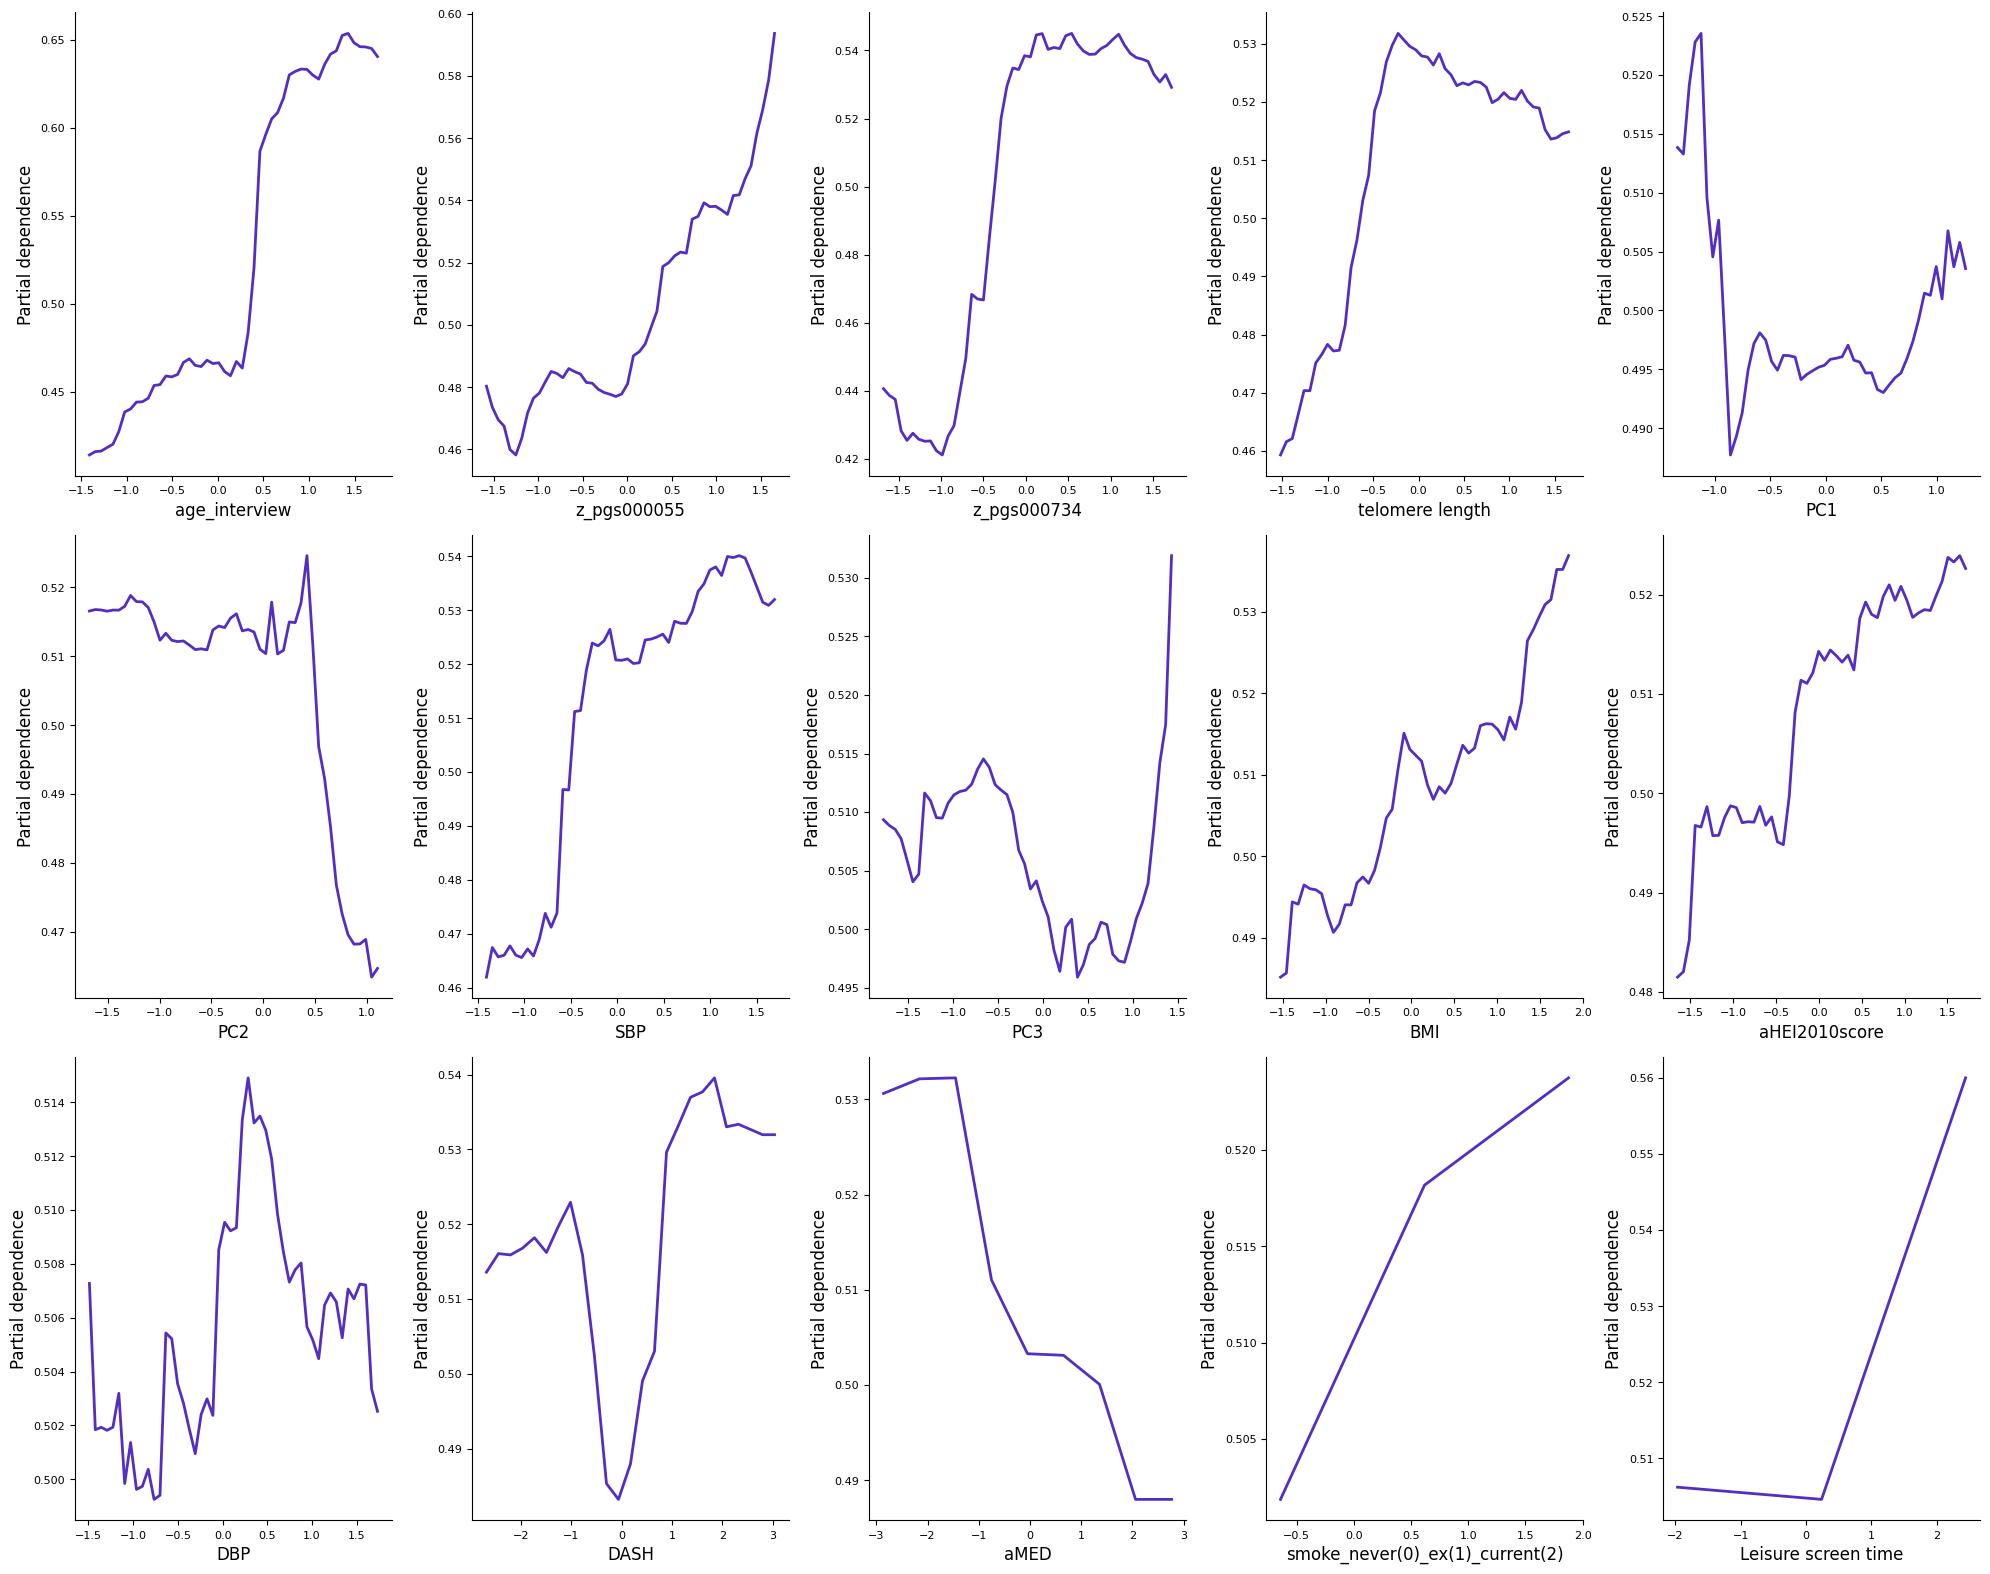

In [8]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
})
top_20_features = importances.nlargest(15, 'importance')['feature'].values

fig, axes = plt.subplots(3, 5, figsize=(20, 16), facecolor='white')
fig.suptitle('', fontsize=16)
plt.subplots_adjust(wspace=1, hspace=1)

axes = axes.ravel()

for idx, feature in enumerate(top_20_features):
    pdp_results = partial_dependence(
        rf,
        X_train_scaled,
        [feature],
        percentiles=(0.05, 0.95),
        grid_resolution=50,
        kind='average'
    )
    feature_values = pdp_results['grid_values'][0]
    pdp_values = pdp_results['average'][0]

    ax = axes[idx]
    ax.plot(feature_values, pdp_values, color='#532dc4', linewidth=2)
    ax.grid(True, color='white', linewidth=1.5)
    ax.tick_params(axis='both', which='major', labelsize=8)
    # ax.set_facecolor('#e7e6e6') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("Partial dependence", fontsize=12)


for idx in range(len(top_20_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

#### Try Oversampling

In [5]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)
df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test_scaled)
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

cv_scores = cross_val_score(
    rf, X_train_resampled, y_train_resampled, 
    cv=5, scoring='roc_auc'
)
print("\nCross-validation ROC AUC scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("CV Score Std:", cv_scores.std())


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4031
           1       0.02      0.01      0.01       107

    accuracy                           0.96      4138
   macro avg       0.50      0.50      0.50      4138
weighted avg       0.95      0.96      0.96      4138


Confusion Matrix:
[[3983   48]
 [ 106    1]]

ROC AUC Score: 0.5878414252162563

Top 10 Most Important Features:
                            feature  importance
8                              aMED    0.166488
9                              DASH    0.076162
1                     Age_interview    0.074619
17                      z_pgs000734    0.063451
10                              SBP    0.059710
2                               PC1    0.056558
13  smoke_never(0)_ex(1)_current(2)    0.055306
11                              DBP    0.054126
16                      z_pgs000055    0.053842
4                               PC3    0.051924

Cross-

#### Try Downsampling

In [7]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

print("Original class distribution:")
print(pd.Series(y).value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test_scaled)
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

cv_scores = cross_val_score(
    rf, X_train_resampled, y_train_resampled, 
    cv=5, scoring='roc_auc'
)
print("\nCross-validation ROC AUC scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("CV Score Std:", cv_scores.std())

Original class distribution:
colorectal cancer
0    20156
1      533
Name: count, dtype: int64

Resampled class distribution:
colorectal cancer
0    426
1    426
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.58      0.73      4031
           1       0.04      0.60      0.07       107

    accuracy                           0.58      4138
   macro avg       0.51      0.59      0.40      4138
weighted avg       0.96      0.58      0.71      4138


Confusion Matrix:
[[2340 1691]
 [  43   64]]

ROC AUC Score: 0.606750951156574

Top 10 Most Important Features:
          feature  importance
1   Age_interview    0.132197
16    z_pgs000055    0.102974
17    z_pgs000734    0.096723
3             PC2    0.079584
4             PC3    0.071417
10            SBP    0.067636
2             PC1    0.067485
5             BMI    0.064282
7   aHEI2010score    0.063170
11            DBP    0.062310

Cross-validation 

#### Output Probabilities

In [9]:
predicted_probabilities = rf.predict_proba(X)

prob_df = pd.DataFrame(predicted_probabilities, columns=[f'Prob_Class_{i}' for i in range(predicted_probabilities.shape[1])])

result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)

result_df.to_excel('Real_World_Colorectal_Cancer_Predicted_Probabilities.xlsx', index=False)

print("Predicted probabilities exported successfully to 'Real_World_Colorectal_Cancer_Predicted_Probabilities.xlsx'.")


Predicted probabilities exported successfully to 'colorectal_cancer_probabilities.xlsx'.


### Colorectal Cancer Kernel SHAP Experiments

In [4]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

seeds = [42, 123, 456, 789, 1010]
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    background_data = shap.kmeans(X_train_scaled, 100)
    explainer = shap.KernelExplainer(rf.predict_proba, background_data)
    shap_values = explainer.shap_values(X_test_scaled)

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, shap_values)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...


100%|██████████| 214/214 [03:53<00:00,  1.09s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6302631578947369,
                0.606140350877193,
                0.5752631578947368,
                0.5406140350877193,
                0.5599122807017544,
                0.5659649122807018,
                0.5978947368421053,
                0.6121052631578948,
                0.5906140350877193,
                0.5849122807017544,
                0.5724122807017544,
                0.5583771929824561,
                0.5500438596491227,
                0.5241666666666667,
                0.5343421052631578,
                0.5282017543859648,
                0.5099122807017544,
                0.5
            ],
            "cross_entropy": [
                0.6670223646658081,
                0.6770849565208431,
                0.6850209047216567,
                0.6982962530365295,
                0.6958150450509709,
                0.6903248135832901,
                0.681261237311977,

100%|██████████| 214/214 [03:11<00:00,  1.12it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.5667365478686234,
                0.5489168413696716,
                0.5462089447938505,
                0.5564290705800141,
                0.5268169112508735,
                0.5341544374563243,
                0.5566911250873515,
                0.551974143955276,
                0.5701869322152341,
                0.613382250174703,
                0.5910639412997902,
                0.5750349406009783,
                0.5518867924528301,
                0.5045859538784068,
                0.46339972047519223,
                0.47418763102725364,
                0.48226764500349406,
                0.5
            ],
            "cross_entropy": [
                0.7049264917531135,
                0.6961714281118482,
                0.6959773069514985,
                0.6915844636190166,
                0.6997455390309603,
                0.6968987297453553,
                0.68928251895062

100%|██████████| 214/214 [03:16<00:00,  1.09it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.57899366643209,
                0.5702850105559465,
                0.5151301900070373,
                0.4733462350457424,
                0.495249824067558,
                0.4868930330752991,
                0.49859254046446166,
                0.4878606615059817,
                0.4791520056298381,
                0.4802076002814919,
                0.502990851513019,
                0.5059817030260381,
                0.4794159042927516,
                0.42694405348346237,
                0.5203201970443349,
                0.517637227304715,
                0.5224313863476425,
                0.5
            ],
            "cross_entropy": [
                0.6778239856458068,
                0.6945173729489057,
                0.7076193544432913,
                0.7178952266221212,
                0.7104895300197419,
                0.7117006314721035,
                0.7103001795641579,


100%|██████████| 214/214 [03:30<00:00,  1.02it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.5509951348960637,
                0.5345422379478106,
                0.5149933657673595,
                0.5249889429455993,
                0.535249889429456,
                0.5571870853604599,
                0.5461300309597523,
                0.5419725785050863,
                0.558779301194162,
                0.5568332596196375,
                0.5857585139318885,
                0.5375939849624061,
                0.555639097744361,
                0.5530738611233967,
                0.5191950464396285,
                0.5098186643078284,
                0.4874391862007961,
                0.5
            ],
            "cross_entropy": [
                0.7161174979154652,
                0.7027988544128,
                0.7172513398042779,
                0.7207184500252589,
                0.7142463036523006,
                0.698253570291297,
                0.6950637877345943,
    

100%|██████████| 214/214 [04:17<00:00,  1.20s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.5866014499082889,
                0.5906192680583456,
                0.5811861297929949,
                0.5445017032055202,
                0.5466853000262032,
                0.5767315922788016,
                0.5856406673071884,
                0.5575159402567911,
                0.5532360904882523,
                0.5699187701982705,
                0.5918857542143419,
                0.5924534893877195,
                0.6063848371036773,
                0.5655079046204908,
                0.5406149008647044,
                0.5247619879465455,
                0.5046728971962617,
                0.5
            ],
            "cross_entropy": [
                0.6750546269328394,
                0.6755881073608002,
                0.6822251536256889,
                0.689841639441782,
                0.6940584234468913,
                0.6886583248767756,
                0.6803903406514118

In [9]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5407941918848767,
            "std": 0.02233118252686752
        },
        "cross_entropy": {
            "mean": 0.6948535109366066,
            "std": 0.006140986860362134
        },
        "brier": {
            "mean": 0.25069153032935826,
            "std": 0.0029652746528941233
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.6263348546961374,
            "std": 0.01492308295233507
        },
        "cross_entropy": {
            "mean": 0.6766646949925195,
            "std": 0.009090833682949188
        },
        "brier": {
            "mean": 0.2410099516170343,
            "std": 0.004037043695888386
        }
    }
}


### Colorectal Cancer Tree SHAP Experiments

In [3]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

seeds = [42, 123, 456, 789, 1010]
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test_scaled)

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, shap_values)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))



Training Random Forest model...
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6302631578947369,
                0.606140350877193,
                0.5752631578947368,
                0.5406140350877193,
                0.5599122807017544,
                0.5659649122807018,
                0.5978947368421051,
                0.6121052631578948,
                0.610701754385965,
                0.597280701754386,
                0.5724561403508772,
                0.5583771929824561,
                0.5267543859649123,
                0.5241666666666667,
                0.5343421052631578,
                0.5282017543859648,
                0.5099122807017544,
                0.5
            ],
            "cross_entropy": [
                0.6670223646658081,
                0.6770849565208431,
                0.6850209047216567,
                0.6982962530365298,
                0.6958150450509708,
                0.6903248135832902,
    

In [7]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5394816086921512,
            "std": 0.021389699529343352
        },
        "cross_entropy": {
            "mean": 0.6951038520540607,
            "std": 0.006184570012059086
        },
        "brier": {
            "mean": 0.25081647002018836,
            "std": 0.003005757801739175
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.6265093545184001,
            "std": 0.015601551687072824
        },
        "cross_entropy": {
            "mean": 0.6765534219670576,
            "std": 0.009482067393342343
        },
        "brier": {
            "mean": 0.240974946736838,
            "std": 0.004183197456195854
        }
    }
}


### Colorectal Cancer Causal SHAP Experiments

In [8]:
import pickle

base_dir = '../../'
result_dir = base_dir + 'result/R/'

data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)
    
df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

file_paths = ['../../result/CCancer/Causal_SHAP_CCancer_42.pkl', '../../result/CCancer/Causal_SHAP_CCancer_123.pkl', '../../result/CCancer/Causal_SHAP_CCancer_456.pkl', '../../result/CCancer/Causal_SHAP_CCancer_789.pkl', '../../result/CCancer/Causal_SHAP_CCancer_1010.pkl']

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

feature_names = X.columns.tolist()
causal_shap_values = []

for file_path in file_paths:
    formatted_values = load_and_format_shap_values(file_path, feature_names)
    causal_shap_values.append(formatted_values)

In [9]:
seeds = [42, 123, 456, 789, 1010]

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf.fit(X_train_scaled, y_train)

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, pd.Series(np.abs(causal_shap_values[idx]).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6481578947368422,
                0.6242105263157894,
                0.5752631578947368,
                0.5614035087719298,
                0.5646491228070175,
                0.5942105263157895,
                0.6163157894736842,
                0.6042982456140351,
                0.5719298245614035,
                0.5728070175438597,
                0.5654824561403509,
                0.5626754385964913,
                0.5499122807017544,
                0.557938596491228,
                0.5343421052631578,
                0.5282017543859648,
                0.5217543859649124,
                0.5
            ],
            "cross_entropy": [
                0.6556514921159328,
                0.6760014314792019,
                0.6850209047216567,
                0.6875990305385987,
                0.6849462423705724,
                0.6762331660386214,
  

In [10]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5534451966444145,
            "std": 0.00933700153156182
        },
        "cross_entropy": {
            "mean": 0.6910201881251979,
            "std": 0.004460438036571515
        },
        "brier": {
            "mean": 0.24882677264369554,
            "std": 0.002145223900716154
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.6271642663840172,
            "std": 0.0190426133118931
        },
        "cross_entropy": {
            "mean": 0.6735582963032829,
            "std": 0.009696518565277585
        },
        "brier": {
            "mean": 0.23972168979116243,
            "std": 0.0044048947404250255
        }
    }
}


## Keywords 
1. Shapley Flow
2. Independent SHAP
3. Kernel SHAP
4. On Manifold SHAP
5. ASV
6. Causal SHAP
7. The ground truth using Exact SHAP

## Independent SHAP

In [19]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

seeds = [42, 123, 456, 789, 1010]
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    #########################

    def predict_proba_class1(X):
        return rf.predict_proba(X)[:, 1]  

    explainer = IndExplainer(predict_proba_class1, X_train)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6324561403508772,
                0.6242105263157894,
                0.6303508771929824,
                0.6290350877192982,
                0.62,
                0.6170175438596492,
                0.6156140350877193,
                0.609298245614035,
                0.6109649122807017,
                0.6167543859649122,
                0.6183333333333334,
                0.6199122807017544,
                0.6335087719298247,
                0.5712719298245613,
                0.5394736842105263,
                0.5445614035087719,
                0.528859649122807,
                0.5
            ],
            "cross_entropy": [
                0.6723363157314303,
                0.6760014314792019,
                0.6819368729529631,
                0.6846632873255166,
                0.6972894269086223,
                0.6957235099223988,
                0.694725396572143,
              

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6242138364779873,
                0.6351327742837177,
                0.6510307477288609,
                0.6413347309573725,
                0.6536512928022362,
                0.6522536687631026,
                0.655398322851153,
                0.6557477288609365,
                0.6698986722571628,
                0.662561146051712,
                0.6550489168413697,
                0.6590670859538784,
                0.6518169112508736,
                0.6549615653389238,
                0.5818046820405312,
                0.5201345213137665,
                0.4779437456324248,
                0.5
            ],
            "cross_entropy": [
                0.6774325936384296,
                0.6710615738850861,
                0.6674809742689742,
                0.6776435444456638,
                0.6729330643325531,
                0.67888530785955,
                0.6840365049987318,
 

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6096059113300493,
                0.5979064039408868,
                0.6016009852216748,
                0.615411681914145,
                0.6176988036593948,
                0.6038001407459536,
                0.5935080928923293,
                0.5978184377199155,
                0.5996657283603096,
                0.5985221674876847,
                0.5716045038705136,
                0.5642153413089374,
                0.55137227304715,
                0.5625439831104855,
                0.5590253342716397,
                0.48126319493314573,
                0.4735661505981703,
                0.5
            ],
            "cross_entropy": [
                0.6928722902785657,
                0.6935783260997594,
                0.6905761000061288,
                0.6889902334813374,
                0.6902511452235205,
                0.6965527641574341,
                0.702930093042062,


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.612295444493587,
                0.6028306059265811,
                0.598938522777532,
                0.5758513931888545,
                0.5721362229102167,
                0.5847854931446262,
                0.5814241486068111,
                0.5766475011057054,
                0.5821318000884564,
                0.5849624060150376,
                0.5859354268022999,
                0.5857585139318886,
                0.5786819991154356,
                0.4958867757629367,
                0.5214949137549756,
                0.48659885006634235,
                0.5214506855373728,
                0.5
            ],
            "cross_entropy": [
                0.6754977431840007,
                0.6839150271870824,
                0.6864670964336101,
                0.7013868760193777,
                0.7086209822017934,
                0.7044585785130001,
                0.7027652726640023

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6574373307712464,
                0.6574373307712463,
                0.6539435758581535,
                0.6418027775351558,
                0.6393571490959908,
                0.6341165167263516,
                0.6241156432876234,
                0.6242466590968643,
                0.6221504061490086,
                0.5527120272512884,
                0.5114857192767928,
                0.4926194427460914,
                0.5155035374268495,
                0.5227967508079308,
                0.5212245610970391,
                0.5355489562407196,
                0.5317494977727313,
                0.5
            ],
            "cross_entropy": [
                0.6626124380898827,
                0.661509646191552,
                0.6579489791169905,
                0.672203055102155,
                0.673913847537685,
                0.6798096244321185,
                0.6800263408663734,


In [20]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5872090097330631,
            "std": 0.02086282220780693
        },
        "cross_entropy": {
            "mean": 0.6931391527635029,
            "std": 0.007574378846690072
        },
        "brier": {
            "mean": 0.2486724443794229,
            "std": 0.0031863968821754453
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.5886328932786842,
            "std": 0.03375482756185998
        },
        "cross_entropy": {
            "mean": 0.6893523476517662,
            "std": 0.01753895545847544
        },
        "brier": {
            "mean": 0.2475994376288611,
            "std": 0.008094301602267219
        }
    }
}


## On Manifold

In [ ]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

seeds = [42, 123, 456, 789, 1010]
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    #########################

    def predict_proba_class1(X):
        return rf.predict_proba(X)[:, 1]  
    
    bg_mean = pd.DataFrame(X_train_scaled.mean()).T

    explainer = OnManifoldExplainer(predict_proba_class1, pd.concat([bg_mean, X_test_scaled]))

    shap_values = explainer.shap_values(X_test_scaled)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test_scaled.columns) 
    #########################

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))





Training Random Forest model...


manifold bg samples: 100%|██████████| 214/214 [4:05:35<00:00, 68.86s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6302631578947369,
                0.606140350877193,
                0.5752631578947368,
                0.5406140350877193,
                0.5715789473684211,
                0.585,
                0.5821929824561403,
                0.6035964912280702,
                0.5959649122807018,
                0.5718421052631579,
                0.5710526315789474,
                0.5913157894736842,
                0.5881578947368421,
                0.5735526315789474,
                0.48964912280701756,
                0.5282017543859648,
                0.5217543859649124,
                0.5
            ],
            "cross_entropy": [
                0.6670223646658081,
                0.6770849565208431,
                0.6850209047216567,
                0.6982962530365299,
                0.6883634338665875,
                0.6865049482369576,
                0.6847826589483634,
          

manifold bg samples: 100%|██████████| 214/214 [3:46:42<00:00, 63.56s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.5667365478686234,
                0.5489168413696716,
                0.5462089447938505,
                0.5111809923130678,
                0.5268169112508735,
                0.5211390635918938,
                0.504979035639413,
                0.5,
                0.4942348008385744,
                0.5419287211740043,
                0.506114605171209,
                0.5392208245981831,
                0.5518867924528301,
                0.5527603074772887,
                0.5522361984626135,
                0.5618448637316561,
                0.48226764500349406,
                0.5
            ],
            "cross_entropy": [
                0.7049264917531135,
                0.6961714281118482,
                0.6959773069514985,
                0.7037488087960087,
                0.6997455390309603,
                0.7038770290901525,
                0.7047023072976846,
             

manifold bg samples: 100%|██████████| 214/214 [5:02:23<00:00, 84.78s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.57899366643209,
                0.5702850105559465,
                0.5299964813511613,
                0.4733462350457424,
                0.476073187895848,
                0.5008796622097114,
                0.49859254046446166,
                0.4953377902885292,
                0.4913793103448275,
                0.4839021815622801,
                0.4656052076002815,
                0.47690886699507384,
                0.4317382125263899,
                0.42694405348346237,
                0.5203201970443349,
                0.5145144264602393,
                0.5224313863476425,
                0.5
            ],
            "cross_entropy": [
                0.6778239856458068,
                0.6945173729489057,
                0.7059986122280728,
                0.7178952266221212,
                0.7148329664590048,
                0.7084092776284817,
                0.710300179564157

manifold bg samples: 100%|██████████| 214/214 [5:17:18<00:00, 88.97s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.5509951348960637,
                0.5345422379478106,
                0.5149933657673595,
                0.5249889429455993,
                0.535249889429456,
                0.5232198142414861,
                0.5442724458204334,
                0.5152587350729766,
                0.5285272003538257,
                0.5299425033171165,
                0.5310039805395842,
                0.5634232640424591,
                0.5351614329942503,
                0.5203449800973021,
                0.5191950464396285,
                0.5098186643078284,
                0.4874391862007961,
                0.5
            ],
            "cross_entropy": [
                0.7161174979154652,
                0.7027988544128,
                0.7172513398042777,
                0.7207184500252589,
                0.7142463036523006,
                0.7217087133276404,
                0.7050699922485588,
 

manifold bg samples: 100%|██████████| 214/214 [4:54:33<00:00, 82.59s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.5866014499082889,
                0.5906192680583456,
                0.5811861297929949,
                0.5445017032055202,
                0.5466853000262032,
                0.5590881299676828,
                0.5734998689841908,
                0.5983928727399773,
                0.5886977028561446,
                0.6101406236352519,
                0.6051183509476811,
                0.5888723906017994,
                0.5791335487815531,
                0.5657699362389729,
                0.5620578216438117,
                0.5202201065595249,
                0.5046728971962617,
                0.5
            ],
            "cross_entropy": [
                0.6750546269328394,
                0.6755881073608002,
                0.6822251536256889,
                0.689841639441782,
                0.6940584234468913,
                0.688428526920375,
                0.6883767872283364,

In [ ]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5373944087642294,
            "std": 0.026879968217018973
        },
        "cross_entropy": {
            "mean": 0.6988808633763783,
            "std": 0.008160754836128893
        },
        "brier": {
            "mean": 0.252625383876206,
            "std": 0.003918785325529485
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.6243932674698546,
            "std": 0.013283579251187951
        },
        "cross_entropy": {
            "mean": 0.6781629124427541,
            "std": 0.00817829582980997
        },
        "brier": {
            "mean": 0.24164909819176428,
            "std": 0.003544376473775057
        }
    }
}


## Shapley Flow

In [15]:
z_pgs000055 = Node('z_pgs000055')
z_pgs000734 = Node('z_pgs000734')
PC1 = Node('PC1')
sex = Node('sex')
age_interview = Node('age_interview')
telomere_length = Node('telomere length')
aMED = Node('aMED')
aHEI2010score = Node('aHEI2010score')
DASH = Node('DASH')
alcohol = Node('alcohol_DailyandWeekly(1)vsMonthlyandNonDrinkers(0)')
SBP = Node('SBP')
DBP = Node('DBP')
BMI = Node('BMI')
smoking = Node('smoke_never(0)_ex(1)_current(2)')
diabetes = Node('Prevalent_diabetes')
prob_class = Node('Prob_Class_1', is_target_node=True)

# Define nodes with their dependencies and causal effects
PC1 = Node(
    'PC1',
    lambda z_pgs000055: 0.1572552 * z_pgs000055,
    [z_pgs000055]
)

telomere_length = Node(
    'telomere length',
    lambda sex, age_interview: (
        0.1263913 * sex + 
        -0.2448397 * age_interview
    ),
    [sex, age_interview]
)

aMED = Node(
    'aMED',
    lambda PC1, aHEI2010score: (
        -0.1023751 * PC1 + 
        0.5563363 * aHEI2010score
    ),
    [PC1, aHEI2010score]
)

DASH = Node(
    'DASH',
    lambda sex, aHEI2010score, aMED, alcohol: (
        0.1882602 * sex + 
        0.7234351 * aHEI2010score + 
        0.3303320 * aMED + 
        -0.1975650 * alcohol
    ),
    [sex, aHEI2010score, aMED, alcohol]
)

SBP = Node(
    'SBP',
    lambda sex, age_interview, DBP: (
        -0.1036026 * sex + 
        0.3082360 * age_interview + 
        0.7818507 * DBP
    ),
    [sex, age_interview, DBP]
)

DBP = Node(
    'DBP',
    lambda sex, BMI: (
        -0.1636155 * sex + 
        0.2298667 * BMI
    ),
    [sex, BMI]
)

smoking = Node(
    'smoke_never(0)_ex(1)_current(2)',
    lambda sex, age_interview: (
        -0.4890412 * sex + 
        0.1217905 * age_interview
    ),
    [sex, age_interview]
)

alcohol = Node(
    'alcohol_DailyandWeekly(1)vsMonthlyandNonDrinkers(0)',
    lambda sex, aHEI2010score, smoking: (
        -0.2505055 * sex + 
        0.1251162 * aHEI2010score + 
        0.1106950 * smoking
    ),
    [sex, aHEI2010score, smoking]
)

diabetes = Node(
    'Prevalent_diabetes',
    lambda age_interview, SBP: (
        0.1084757 * age_interview + 
        0.3063958 * SBP
    ),
    [age_interview, SBP]
)

z_pgs000734 = Node(
    'z_pgs000734',
    lambda z_pgs000055: 0.5795468 * z_pgs000055,
    [z_pgs000055]
)

prob_class = Node(
    'Prob_Class_1',
    lambda z_pgs000055, z_pgs000734: (
        0.5527110 * z_pgs000055 + 
        0.6518316 * z_pgs000734
    ),
    [z_pgs000055, z_pgs000734],
    is_target_node=True
)

# Create the graph with all nodes
nodes = [
    z_pgs000055, z_pgs000734, PC1, sex, age_interview, 
    telomere_length, aMED, aHEI2010score, DASH, alcohol,
    SBP, DBP, BMI, smoking, diabetes, prob_class
]

graph = Graph(nodes)

In [16]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

seeds = [42, 123, 456, 789, 1010]
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    #########################
    def predict_proba_class1(X):
        return rf.predict_proba(X)[:, 1]  
    
    bg_mean = pd.DataFrame(X_train.mean()).T

    graph_explainer = GraphExplainer(graph, bg_mean)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6478947368421052,
                0.647719298245614,
                0.6217543859649123,
                0.6290350877192982,
                0.62,
                0.6170175438596492,
                0.6112280701754386,
                0.5740350877192983,
                0.5489473684210526,
                0.5531140350877193,
                0.5812280701754386,
                0.5531578947368422,
                0.5410964912280702,
                0.5687280701754387,
                0.5553947368421053,
                0.5328070175438596,
                0.5099122807017544,
                0.5
            ],
            "cross_entropy": [
                0.6553260349858836,
                0.6582012182527055,
                0.6805364872938762,
                0.6846632873255166,
                0.6972894269086223,
                0.695723509922399,
                0.699421652360559,
              

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6395003494060099,
                0.6351327742837177,
                0.6483228511530399,
                0.6645702306079664,
                0.6536512928022362,
                0.6522536687631026,
                0.6427323549965059,
                0.6436932215234102,
                0.6529524807826695,
                0.6428197064989517,
                0.6441299790356394,
                0.6457023060796645,
                0.6484102026554858,
                0.596785464709993,
                0.5929856743535988,
                0.524327393431167,
                0.5422781271837875,
                0.5
            ],
            "cross_entropy": [
                0.6670410966917639,
                0.671061573885086,
                0.6644782165378439,
                0.6618406014229035,
                0.6729330643325531,
                0.6788853078595501,
                0.6869834473943205,


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.632125263898663,
                0.6167311752287123,
                0.6064391273750881,
                0.6081984517945109,
                0.6176988036593948,
                0.6038001407459536,
                0.5935080928923293,
                0.5978184377199155,
                0.5981703026038001,
                0.5755629838142154,
                0.5760907811400422,
                0.5767945109078114,
                0.5665024630541872,
                0.5643912737508796,
                0.5543191414496832,
                0.5484693877551021,
                0.5224313863476425,
                0.5
            ],
            "cross_entropy": [
                0.6694443190193395,
                0.6898015668321223,
                0.6915496146218408,
                0.6895520403795329,
                0.6902511452235205,
                0.6965527641574341,
                0.702930093042062,

100%|██████████| 100/100 [01:25<00:00,  1.18it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.612295444493587,
                0.6090225563909775,
                0.5969924812030075,
                0.5754975674480318,
                0.5721362229102167,
                0.5847854931446262,
                0.5814241486068111,
                0.5754975674480318,
                0.5165855816010615,
                0.5299425033171163,
                0.534719150818222,
                0.5431225121627598,
                0.5448031844316673,
                0.5221583370190181,
                0.5306943830163644,
                0.5145510835913313,
                0.46054842989827516,
                0.5
            ],
            "cross_entropy": [
                0.6754977431840007,
                0.6801193226513824,
                0.6902886428782579,
                0.7067864279162024,
                0.7086209822017934,
                0.7044585785130001,
                0.7027652726640023

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6574373307712464,
                0.6574373307712463,
                0.6539435758581535,
                0.6418027775351558,
                0.6393571490959908,
                0.6341165167263516,
                0.6241156432876234,
                0.6230238448772818,
                0.617608524761988,
                0.6128046117564852,
                0.6197047777098437,
                0.6242466590968644,
                0.6252947855707922,
                0.6059917896759542,
                0.6063411651672634,
                0.5440649838413836,
                0.5424491221940781,
                0.5
            ],
            "cross_entropy": [
                0.6626124380898827,
                0.6615096461915518,
                0.6579489791169905,
                0.6722030551021548,
                0.673913847537685,
                0.6798096244321185,
                0.6800263408663733,

In [17]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5886320801560254,
            "std": 0.025433254329828486
        },
        "cross_entropy": {
            "mean": 0.6908968585045929,
            "std": 0.009279165884353287
        },
        "brier": {
            "mean": 0.24776331894613507,
            "std": 0.003823349147674742
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.586893679551393,
            "std": 0.026201094181342054
        },
        "cross_entropy": {
            "mean": 0.6864782912738074,
            "std": 0.014867817378163176
        },
        "brier": {
            "mean": 0.24638029168927403,
            "std": 0.0069028667613139074
        }
    }
}


## ASV

In [21]:
data_path = '../../dataset/Real_World_Colorectal_Cancer.xlsx'
df = pd.read_excel(data_path)

df = df.drop(columns=['Follow-up time', 'SERNO'])
df = df.dropna()

X = df.drop(columns=['colorectal cancer'])
y = df['colorectal cancer']

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

seeds = [42, 123, 456, 789, 1010]
for i in seeds:
    print("Training Random Forest model...")

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=i
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    #########################

    def predict_proba_class1(X):
        return rf.predict_proba(X)[:, 1]  
    
    bg_mean = pd.DataFrame(X_train.mean()).T

    orderings = [
    [
        # Root causes (Level 0)
        0,   # sex
        1,   # age_interview
        5,   # BMI
        7,   # aHEI2010score
        16,  # z_pgs000055
        
        # Level 1 intermediates
        2,   # PC1
        3,   # PC2
        4,   # PC3 
        11,  # DBP
        13,  # smoke_never(0)_ex(1)_current(2)
        
        # Level 2 intermediates
        10,  # SBP
        8,   # aMED
        12,  # Leisure screen time 
        14,  # alcohol_DailyandWeekly(1)vsMonthlyandNonDrinkers(0)
        
        # Terminal nodes (Level 3)
        6,   # telomere_length
        9,   # DASH
        15,  # Prevalent_diabetes
        17,  # z_pgs000734
    ]
]

    explainer = OnManifoldExplainer(predict_proba_class1, pd.concat([bg_mean, X_test]), orderings=orderings)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################

    result = evaluate_global_shap_scores(rf, X_test_scaled, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...


manifold bg samples: 100%|██████████| 214/214 [4:17:31<00:00, 72.20s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6349999999999999,
                0.6424561403508773,
                0.6182456140350877,
                0.6189473684210526,
                0.6176315789473684,
                0.5390350877192982,
                0.5468421052631579,
                0.5698245614035086,
                0.5803508771929825,
                0.6068421052631578,
                0.5840350877192984,
                0.5899561403508772,
                0.5515350877192982,
                0.5404385964912282,
                0.5216228070175438,
                0.5102631578947369,
                0.5128947368421053,
                0.5
            ],
            "cross_entropy": [
                0.6611777017154833,
                0.6609070034324713,
                0.677640699457392,
                0.6776735279754286,
                0.6769204436957766,
                0.6937240519515321,
                0.6906113055384325

manifold bg samples: 100%|██████████| 214/214 [3:55:48<00:00, 66.12s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6125960866526904,
                0.6250873515024459,
                0.6268343815513626,
                0.6295422781271838,
                0.5408805031446541,
                0.5421034241788959,
                0.5268169112508735,
                0.5289133473095737,
                0.528738644304682,
                0.5593990216631727,
                0.555293501048218,
                0.5421470999301188,
                0.45994933612858147,
                0.46265723270440245,
                0.50777428371768,
                0.47418763102725364,
                0.48226764500349406,
                0.5
            ],
            "cross_entropy": [
                0.6796554387724256,
                0.6720497012517656,
                0.6759146690890364,
                0.6756457540609523,
                0.6958411514013743,
                0.6937136410785496,
                0.697881458446821

manifold bg samples: 100%|██████████| 214/214 [5:10:29<00:00, 87.05s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6228008444757213,
                0.5979064039408868,
                0.5995777621393384,
                0.6030084447572133,
                0.6105735397607319,
                0.6173469387755102,
                0.610045742434905,
                0.5634236453201971,
                0.5394088669950738,
                0.5371217452498241,
                0.5539232934553132,
                0.5555946516537649,
                0.5138986629134412,
                0.505058057705841,
                0.4896199859254046,
                0.502375087966221,
                0.5224313863476425,
                0.5
            ],
            "cross_entropy": [
                0.6763321123191829,
                0.6935783260997594,
                0.691830641260382,
                0.6897672788803236,
                0.6847476157262371,
                0.6862866939801161,
                0.6905128733662729,
 

manifold bg samples: 100%|██████████| 214/214 [5:21:41<00:00, 90.19s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6155683325961964,
                0.5977885891198584,
                0.6095532950022113,
                0.612826183104821,
                0.5176470588235293,
                0.5281733746130031,
                0.5282618310482088,
                0.5426802299867315,
                0.5570986289252543,
                0.5845643520566121,
                0.5811587793011941,
                0.5763821318000885,
                0.5705440070765149,
                0.59031402034498,
                0.5685979655019903,
                0.588235294117647,
                0.5961963732861566,
                0.5
            ],
            "cross_entropy": [
                0.682122477569109,
                0.7001097574591894,
                0.6840979858202227,
                0.6803640334555818,
                0.7218126672587563,
                0.7172406724272133,
                0.7244959646875228,
  

manifold bg samples: 100%|██████████| 214/214 [4:51:27<00:00, 81.72s/it]  


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.6512359158005065,
                0.6568259236614551,
                0.6545549829679448,
                0.6621538999039218,
                0.6752554808280199,
                0.676652982793257,
                0.5944623984627478,
                0.5869508253995982,
                0.5426238099397327,
                0.5382129443619531,
                0.5321862171368679,
                0.5196960433225609,
                0.5111800157218971,
                0.5348502052581011,
                0.537688881124989,
                0.5321862171368679,
                0.5317494977727313,
                0.5
            ],
            "cross_entropy": [
                0.6568587014453968,
                0.6532955782565393,
                0.6559545017089502,
                0.6563743988772669,
                0.649729963006843,
                0.6526467344113771,
                0.6806154072144096,


In [22]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5637697942221338,
            "std": 0.014144191556430295
        },
        "cross_entropy": {
            "mean": 0.6893169566553404,
            "std": 0.005090263767688893
        },
        "brier": {
            "mean": 0.24790895532191398,
            "std": 0.0022534084989575894
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.617745674885944,
            "std": 0.017057137284952804
        },
        "cross_entropy": {
            "mean": 0.6750127046676088,
            "std": 0.008755651271412994
        },
        "brier": {
            "mean": 0.24066720497148478,
            "std": 0.003986130443313663
        }
    }
}
